# Giant number fluctuations experiment notebook in DF project

## General guidelines
- This notebook is for experimenting the giant number fluctuations figures for DF project.
- Finalized figure should be implemented in the `Figure.ipynb` notebook.

## <font color='blue'> Plans

<font color='blue'>
    
- In GNF curves, there is always a kink when $l^2/l_b^2\approx 65$, please figure out why.
</font>

## Table of contents

1. Concentration dependence
    - Helper functions
        - GNF data postprocessing: `postprocess_gnf()
        - Combine multiple data to one curve with errorbar: `collapse_data()`
        - Prepare multiple data: `prepare_multiple_data()`
        - Compare with predictions from theory and simulation: `plot_predictions()`
    - Plot using the functions we just defined
        - $\Delta N / \sqrt N$ vs. $l^2$ at various concentrations
        - $\alpha$ vs. concentration
    - Some thoughts on the fitting range of $\alpha$
2. GNF kinetics
    - Helper functions
        - $\Delta N / \sqrt N$ vs. $l^2$ at differnet times: `plot_std()`
        - $\alpha$ and image intensity vs. $t$: `plot_kinetics()`
        - Move light on time to 0: `kinetics_from_light_on()`
        - Plot energy, order and GNF together: `plot_kinetics_eo()`
        - Move light-on time to 0 for plot_kinetics_eo() data: `kinetics_eo_from_light_on()`
        - Smoothing the data: `kinetics_eo_smooth()`
    - Plot kinetics using the functions defined above

## 0 Packages and presets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor, bpass, wowcolor
from skimage import io, measure
import pandas as pd
from scipy.signal import savgol_filter, medfilt
import os
import corrLib
from numpy.polynomial.polynomial import polyvander
from scipy.optimize import curve_fit
from miscLib import label_slope
from scipy import signal
from scipy.interpolate import griddata
import matplotlib
import pandas as pd
from scipy.ndimage import gaussian_filter1d, uniform_filter1d
import typesetting.main as tm
from corr_utils import *
from IPython.display import clear_output

In [2]:
color_dict, marker_list = unified_symbols() # keep color and symbol consistent across different plot, for same concentrations
data_master_dir = r'E:\Google Drive' # data folder: Google drive for now, but may change in the future
tm.prl('1-column-2-panel') # control the default plotting configurations, now I realize the parameters should vary from plot to plot
dirs = data_log_mapping(kw='aug') # video info for GNF raw data, obtained from Aug 3rd to Aug 6th

## 1. GNF at different concentrations
### 1.1 Rearrange normalized GNF data
Read raw data from level-2-data folder and process them to be ready for:
- plotting GNF
- comparing GNF and energy spectra

In [ ]:
conc, folders, sample_num = tentative_log()
lb = 10
seg_length = 50
master_file = os.path.join(data_master_dir, r'Research projects\DF\data\level-2-data\{0}\df2_kinetics\{1:02d}\kinetics_data.csv')
out_folder = 'transient-nGNF-energy'
out_filename = 'nGNF_data.csv'
for c, f, s in zip(conc, folders, sample_num):
    for sn in s:
        file = master_file.format(f, sn)
        k_data = pd.read_csv(file)
        volume_fraction = c * 8e-4
        for num, seg in enumerate(k_data.segment.drop_duplicates()):
            subdata = k_data.loc[k_data.segment==seg]
            x, y = postprocess_gnf(subdata, lb, xlim=[1, 10000], sparse=1, normalize='small-scale', volume_fraction=volume_fraction)
            temp = pd.DataFrame(data={'l_r': x, str((seg-1)*seg_length): y}).set_index('l_r')
            if num == 0:
                master = temp
            else:
                master = pd.concat([master, temp], axis=1)
        dest_file = file.replace('level-2-data', out_folder).replace('kinetics_data.csv', out_filename)
        dest_folder = os.path.split(dest_file)[0]
        if os.path.exists(dest_folder) == False:
            os.makedirs(dest_folder)
        master.to_csv(dest_file)
        print("Write {0}-{1:02d}".format(f, sn))
        clear_output(wait=True)

### 1.2 Generate different concentration data from the processed transient data
Save the data in data\GNF.csv file. Generate GNF files for the last 3 segments as GNF.csv (-1), GNF-2.csv (-6) and GNF-3.csv (-9), for averaging data

In [80]:
conc, folders, sample_num = tentative_log()
master_file = os.path.join(data_master_dir, r'Research projects\DF\data\transient-nGNF-energy\{0}\df2_kinetics\{1:02d}\nGNF_data.csv')
master_gnf = pd.DataFrame() # empty DF for storing data of different concentrations
for c, f, s in zip(conc, folders, sample_num):
    file = master_file.format(f, s[1])
    data = pd.read_csv(file).set_index('l_r')
    last_col_name = data.keys()[-9]
    last_col = data[last_col_name].to_frame().rename(columns={last_col_name: str(c)})
    master_gnf = pd.concat([master_gnf, last_col], axis=1)
# master_gnf.to_csv(os.path.join(data_master_dir, r'Research projects\DF\data\GNF\GNF-2.csv'))

### 1.3 Plot GNF curves

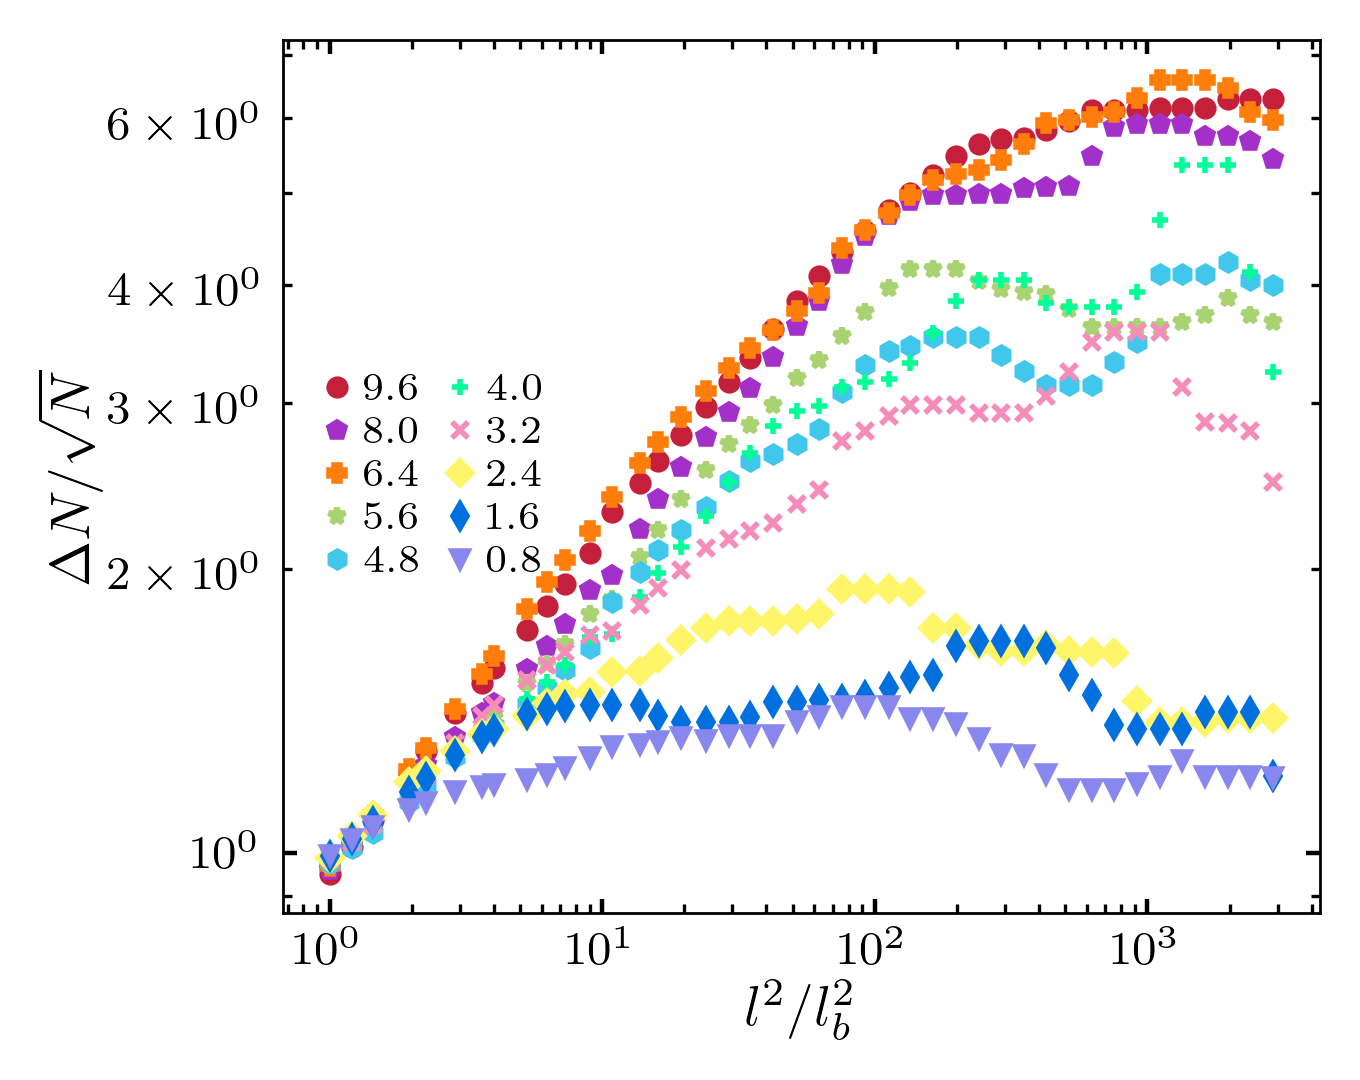

In [87]:
data_gnf = pd.read_csv(os.path.join(data_master_dir, r'Research projects\DF\data\GNF\GNF.csv')).set_index('l_r')
fig, ax = plt.subplots(figsize=(3.5, 2.8))
for str_c in data_gnf:
    if str_c != '85': # don't plot 85 data
        ax.plot(data_gnf.index, signal.medfilt(data_gnf[str_c], 5),
               color=wowcolor(color_dict[str_c]), marker=marker_list[color_dict[str_c]],
               markersize=3, ls='', label='{:.1f}'.format(int(str_c)*0.08))
ax.legend(loc='center left', ncol=2, fontsize=7)
ax.set_xlabel('$l^2/l_b^2$')
ax.set_ylabel('$\Delta N/\sqrt N$')
ax.set_yticks([1, 2, 3, 4, 6])
ax.set_yticklabels(['1', '2', '3', '4', '6'])
ax.loglog()       
plt.tight_layout()

### 1.4 Scaling exponent $\alpha$

#### 1.4.1 Generate $\alpha$ data
The fitting range is **(10, 150)** (lb^2). If changed, also change this line for easier reading.

In [78]:
alpha_data = pd.DataFrame() # empty DF for storing alpha data
for file in ['GNF.csv', 'GNF-2.csv', 'GNF-3.csv']:
    data_gnf = pd.read_csv(os.path.join(data_master_dir, r'Research projects\DF\data\GNF', file)).set_index('l_r')
    data_trim = data_gnf[10: 150]
    alpha_list = []
    for str_c in data_trim:
        data_fit = data_trim[str_c].dropna()
        p = np.polyfit(np.log(data_fit.index), np.log(data_fit), deg=1)
        alpha_list.append(p[0])
    alpha_temp = pd.DataFrame({"conc": data_gnf.keys().astype('int'), file: alpha_list}).set_index('conc').sort_index()
    alpha_data = pd.concat([alpha_data, alpha_temp], axis=1)
alpha_data = alpha_data.assign(mean=alpha_data.mean(axis=1), std=alpha_data.std(axis=1))
# alpha_data.to_csv(os.path.join(data_master_dir, r'Research projects\DF\data\GNF\alpha.csv')) # Save data in data/alpha.csv

#### 1.4.2 Plot $\alpha$ data

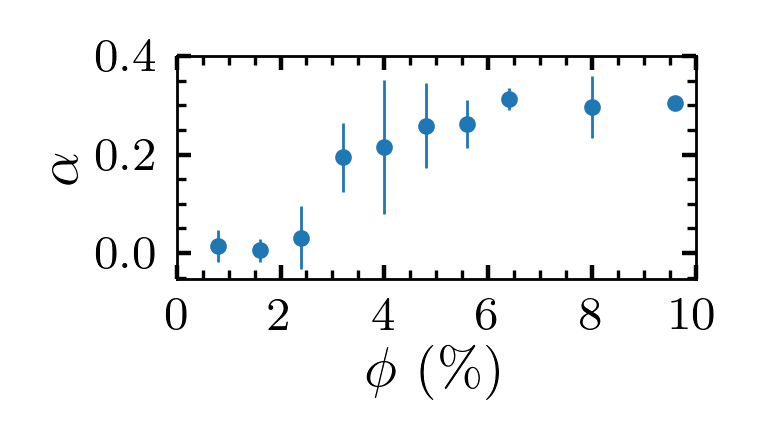

In [81]:
alpha_data = pd.read_csv(os.path.join(data_master_dir, r'Research projects\DF\data\GNF\alpha.csv')).set_index('conc').drop(index=85)
fig, ax = plt.subplots(figsize=(2, 1.2))
ax.errorbar(alpha_data.index*0.08, alpha_data['mean'], yerr=alpha_data['std'],
           ls='', elinewidth=0.5, marker='o', markersize=2)
ax.set_xlabel('$\phi$ (\%)')
ax.set_ylabel('$\\alpha$')
ax.set_xlim([0, 10])
# ax.set_ylim([0, 0.4])
ax.set_yticks([0, 0.2,  0.4])
ax.set_xticks([0, 2, 4, 6, 8, 10])
plt.tight_layout()

## 2 GNF Kinetics

### 2.1 Helper functions
#### 2.1.1 Plot $\Delta N$ as a function of box size at different time

We start off by plotting $\Delta N/\sqrt{N}$ as a function of $l^2/l_b^2$ at different time, like below.
```Python
def plot_std(k_data, seg_length, tlim=None, xlim=None, lb=10, mpp=0.33, fps=10, num_curves=5):
    """
    Args:
    k_data -- kinetics data computed by df2_kinetics.py, has 3 columns (n, d, segment)
    seg_length -- segment length [frame] used in computing kinetics
    tlim -- bounds of time, only plot the data in the bounds (second)
            tlim can be None, int or list of 2 int
                None - plot all t
                int - plot all below tlim
                list - plot between tlim[0] and tlim[1]
    xlim -- box size beyond which the data get cut off (pixel), can be either integer or a list of 2 integers
    lb -- size of single bacterium [px]
    mpp -- microns per pixel
    fps -- frames per second
    num_curve -- number of curves in the final plot
    
    Returns:
    plot_data -- a dict containing (x, y)'s of all the curved plotted
                example {'l1': (x1, y1), 'l2': (x2, y2)} 
                where x1, y1, x2, y2 are all array-like object
    fig -- the figure handle of the plot, use for saving the figure
    ax -- axis of the plot
    """
    ...
    return return plot_data, fig, ax
```

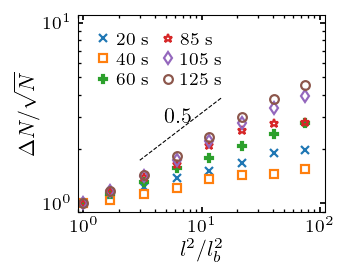

In [2]:
# test plot_std(k_data, seg_length, tlim=None, xlim=None, lb=10, mpp=0.33, fps=10, num_curves=5)
seg_length = 50
k_data = pd.read_csv(r'E:\moreData\06232020\df2_kinetics_norm\01\kinetics_data.csv'.format(seg_length))
plot_data, fig, ax = plot_std(k_data, seg_length, tlim=[20, 150], xlim=[1, 100], lb=10, mpp=0.33, fps=10, num_curves=6)
# guide of the eye slope
x = np.array([3, 15])
y = x**0.5 * 1
ax.plot(x, y, lw=0.5, ls='--', color='black')
ax.text(0.6*x[0]+0.2*x[1], y.mean(), '0.5')
ax.axis([0.9, 110, 0.9, 11])
ax.legend(ncol=2)

#### 2.1.2 Plot $\alpha$ together with light intensity


We can clearly see the effect of light (or velocity) on the giant number fluctuations.
```Python
def plot_kinetics(k_data, i_data, tlim=None, xlim=None, lb=10, mpp=0.33, seg_length=100, fps=10):
    """
    Plot evolution of number fluctuation exponents and light intensity on a same yyplot
    refer to https://matplotlib.org/gallery/api/two_scales.html
    
    Args:
    k_data -- kinetics data computed by df2_kinetics.py
    i_data -- light intensity evolution extracted by overall_intensity.py
    lb -- size of bacteria (pixel, normalizing factor of x axis)
    mpp -- microns per pixel
    seg_length -- segment length when computing kinetics [frame]
    fps -- frames per second
    
    Returns:
    fig -- figure object
    ax1 -- the axis of kinetics
    """
    ...
    return fig, ax1
```

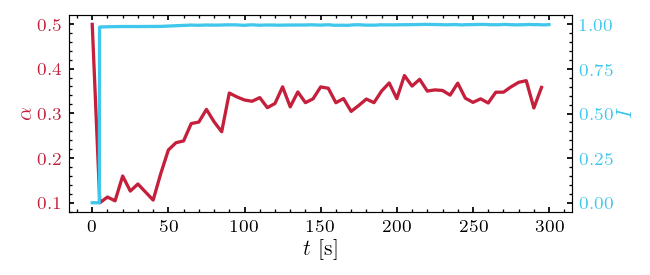

In [2]:
# test plot_kinetics(k_data, i_data, tlim=None, xlim=None, lb=10, mpp=0.33, seg_length=100, fps=10)
tm.prl('1-column-1-panel')
num = 1
seg_length = 50
k_data = pd.read_csv(r'E:\moreData\06232020\df2_kinetics_norm\01\kinetics_data.csv'.format(seg_length, num))
i_data = pd.read_csv(r'E:\moreData\06232020\overall_intensity\{0:02d}\intensity.csv'.format(num))
data, fig, ax1 = plot_kinetics(k_data, i_data, tlim=[0, 300], xlim=[1, 100], lb=10, mpp=0.33, seg_length=seg_length, fps=10)

#### 2.1.3 Move light-on time to 0

In the previous function, light is turned on at 4.8 s instead of 0. As a result, the light intensity curve shows a sudden jump at 4.8 s. A worse thing about the graph is that, the first point of GNF curve has a very high value, due to the sudden change of light intensity in the first computation bracket. Therefore, I design function ```kinetic_from_light_on()``` to replot the data.

In this function, we only plot $\alpha$ as a function of $t$ and do not plot light intensity again since it's always constant and starts from time 0.
```Python
def kinetics_from_light_on(data):
    """
    Args:
    data -- dict of ('t0', 'alpha', 't1', 'i'), return value of plot_kinetics()
    
    Returns:
    new_data -- dict of ('t0', 'alpha', 't1', 'i'), where 't0' and 't1' are translated according to the light on time, so that light is on at time 0.
    """
    ...
    return new_data, fig, ax1
```

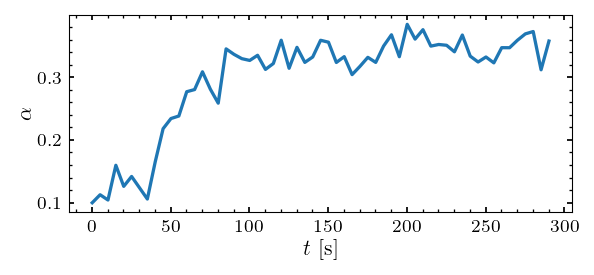

In [5]:
# test kinetic_from_light_on(data)
new_data, fig, ax = kinetics_from_light_on(data)

#### 2.1.4 Plot energy, order and GNF together

**Plot raw data**

This plot allows us to see how GNF evolves with flow energy and flow order, which further provides us insight into the mechanism of giant number fluctuations.
```Python
def plot_kinetics_eo(k_data, i_data, eo_data, tlim=None, xlim=None, lb=10, mpp=0.33, seg_length=100, fps=10):
    """
    Plot evolution of number fluctuation exponents and light intensity on a same yyplot
    In addition, plot flow energy and flow order in the same figure as well
    
    Args:
    k_data -- kinetics data computed by df2_kinetics.py
    i_data -- light intensity evolution extracted by overall_intensity.py
    eo_data -- energy and order data (t, E, OP), t has unit second, computed by energy_order.py
    tlim -- time range in which data is plotted
    xlim -- range for fitting the gnf curve
    lb -- size of bacteria (pixel, normalizing factor of x axis)
    mpp -- microns per pixel
    seg_length -- segment length when computing kinetics [frame]
    fps -- frames per second
    
    Returns:
    fig -- figure object
    ax1 -- the axis of kinetics
    """
    ...
    return data, fig, ax
```

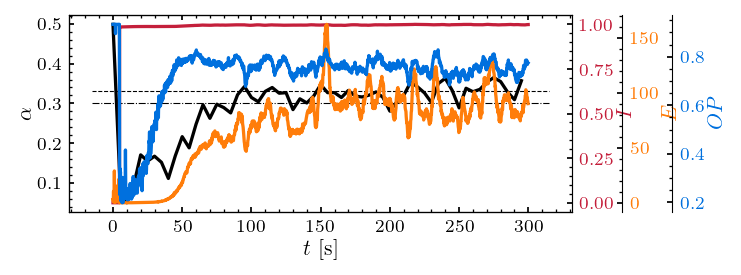

In [3]:
# test plot_kinetics_eo(k_data, i_data, eo_data, tlim=None, xlim=None, lb=10, mpp=0.33, seg_length=100, fps=10)
eo = pd.read_csv(r'E:\moreData\06232020\energy_order\01\energy_order.csv')
k = pd.read_csv(r'E:\moreData\06232020\df2_kinetics_norm\01\kinetics_data.csv')
i = pd.read_csv(r'E:\moreData\06232020\overall_intensity\01\intensity.csv')
data, fig, ax1 = plot_kinetics_eo(k, i, eo, tlim=300, xlim=[1, 10], lb=10, mpp=0.33, seg_length=50, fps=10)
plot_predictions(ax1[0])

#### 2.1.5 Move light-on time to 0 for plot_kinetics_eo() data

In this function, we only plot $\alpha$, $E$ and $OP$ as a function of $t$ and do not plot light intensity again since it's always constant and starts from time 0.
```Python
def kinetics_eo_from_light_on(data):
    """
    Args:
    data -- dict of (t0, alpha, t1, i, t2, E, OP), return value of plot_kinetics_eo()
    
    Returns:
    new_data -- dict of (t0, alpha, t1, i, t2, E, OP), modified so that light-on time is 0
    """
    ...
    return new_data, fig, ax
```

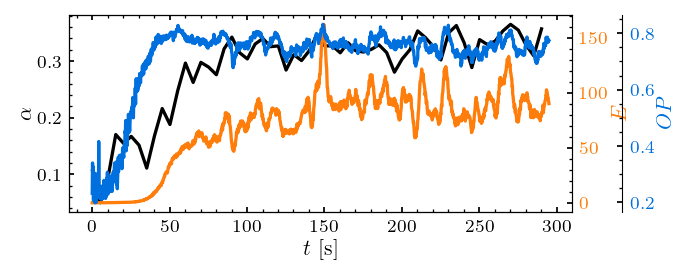

In [4]:
# test kinetics_eo_from_light_on(data)
new_data, fig, ax = kinetics_eo_from_light_on(data)

#### 2.1.6 Smoothing the data

Although the trend in GNF data is pretty obvious, we want to make it smoother by applying an average filter to the data.
```Python
def kinetics_eo_smooth(data):
    """
    Generate smoothed data and plot them.
    
    Args:
    data -- dict of (t0, alpha, t1, i, t2, E, OP), return value of kinetics_eo_from_light_on(data) or plot_kinetics()
    
    Returns:
    new_data -- smoothed data, dict of (t0, alpha, t1, i, t2, E, OP)
    
    Note:
    Although there are many ways to smooth the curve, I apply here a gaussian filter with sigma=1/15*total_data_length to do the work.
    Also try uniform filter with same 'size'   
    """
    ...
    return new_data, fig, ax
```

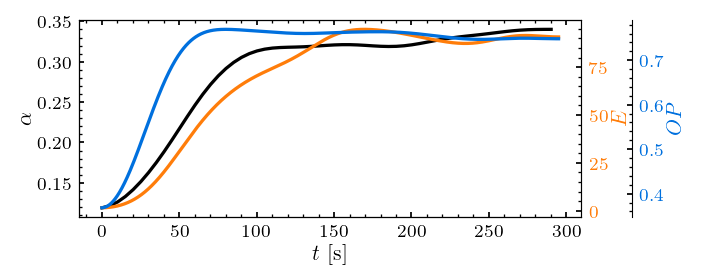

In [5]:
# test kinetics_eo_smooth(data)
nn_data, fig, ax = kinetics_eo_smooth(new_data)

### 2.2 Plot kinetics using the function defined above

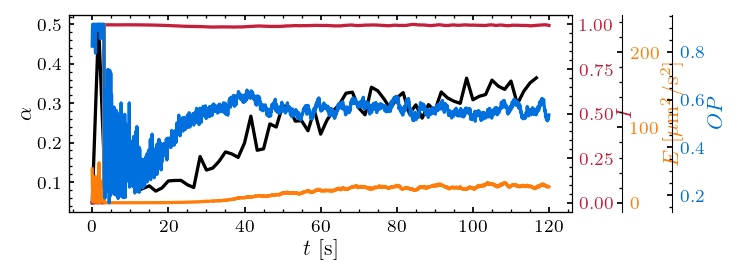

In [15]:
eo = pd.read_csv(r'E:\moreData\08032020\energy_order\02\energy_order.csv')
k = pd.read_csv(r'E:\moreData\08032020\df2_kinetics\02\kinetics_data.csv')
i = pd.read_csv(r'E:\moreData\08032020\overall_intensity\02\intensity.csv')
data, fig, ax = plot_kinetics_eo(k, i, eo, tlim=300, xlim=[0, 120], lb=10, mpp=0.33, seg_length=50, fps=30)

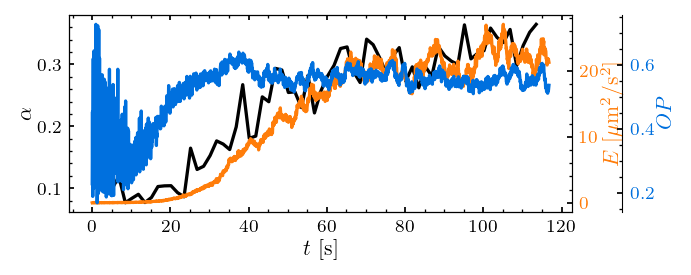

In [16]:
new_data, fig, ax = kinetics_eo_from_light_on(data)

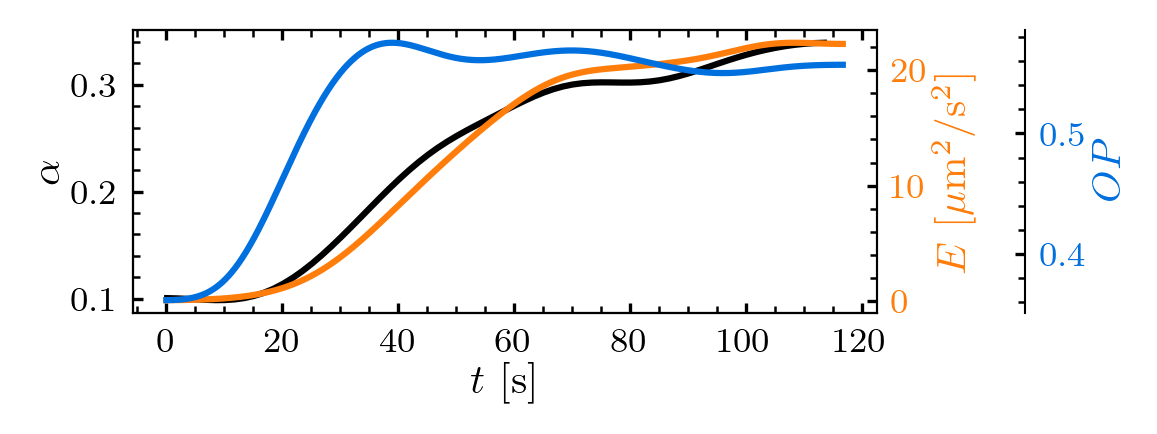

In [17]:
smooth_data, fig, ax = kinetics_eo_smooth(new_data)
ax.set_xlim([-5, 122])

## 3. Explore different ways to normalize GNF curves

### 3.1 The equivalence between $\Delta N/\sqrt N$ and $\Delta I / l$

In the GNF curves above, when plotting $\Delta N/\sqrt N$, the actual data being plotted are $\Delta I / l$, where $I$ is the total pixel intensity in a subsystem and $l$ is the side length of the subsystem. We believe these two quantities are just different by a scaling factor, which does not affect the scaling exponent $\alpha$, so we initially just force the first points of the curves corresponding to different concentrations to be the same, by rescaling the curves with the $y$ value of the first points. 

The basis of this assumption is the following:

- the linear relation between total pixel intensity $I$ and particle volume fraction $\phi$ entails that the variation of $
\Delta I$ is proportional to the variation of total particle number $\Delta N$, given that the total volume is fixed, which is always true in our experiment. The linear relation can be written in the following form
$$
\Delta I = a(n, I_0) \Delta N
$$
where $a(n, I_0)$ is the proportional factor, which is a function of number concentration $n$, and original illumination light intensity $I_0$. To understand the determining factors of $a$, let's first consider imaging a dense and a dilute bacterial suspensions using the same illumination light. As shown in Fig.1 in the paper, the dense suspension results in a image much darker than the dilute one, so that the intensity variation $\Delta I_{dense}$ cannot be larger than the brighter image of the dilute suspension $\Delta I_{dilute}$. However, we know that a denser suspension almost always show larger number fluctuations,  $\Delta N_{dense}>\Delta N_{dilute}$. As a result,
$$
a_{dense} = \frac{\Delta I_{dense}}{\Delta N_{dense}} < \frac{\Delta I_{dilute}}{\Delta N_{dilute}} = a_{dilute}
$$
This example shows the density dependence of the scaling factor $a$. Now let's turn to the illumination condition $I_0$ dependence. Consider the scenario where we image the same bacterial suspension with two different illumination intensity $I_low$ and $I_high$. A higher intensity does not scale up every pixel intensity proportionally. As a result, the difference between the lowest intensity and highest intensity gets larger, so does the temporal variation. For the same number fluctuations $\Delta N$, higher illumination intenstiy $I_{high}$ results in a higher intensity fluctuation $\Delta I_{high}$, which is higher than the low intensity counterpart $\Delta I_{low}$. Thus,
$$
a_{high} = \frac{\Delta I_{high}}{\Delta N} > \frac{\Delta I_{low}}{\Delta N} = a_{low}
$$
Although $a$ is highly dependent on experimental conditions, within in each measurement, where both $n$ and $I_0$ are constant through out the whole run, $a$ can be considered as a constant and we can write $\Delta I = a \Delta N$ for each experiment.

- The number of particles in a subsystem $N$ can be calculated by
$$
N = nl^2d
$$
where $d$ is the sample thickness. Again, it's dependent on the number density $n$ and will vary upon experimental conditions. However, within each experiment, $n$ is constant.

- We combine the two key relations above to get
$$
\frac{\Delta I}{l} = a\sqrt{nd}\frac{\Delta N}{\sqrt N}
$$
where we see, in a specific experimental condition, $\frac{\Delta I}{l}$ and $\frac{\Delta N}{\sqrt N}$ are only different by a constant $a\sqrt{nd}$, which does not affect the scaling exponent $\alpha$.

### 3.2 The need for normalization when comparing different concentrations

Although $\Delta I/l$ is satisfactory when we are interested only in extracting $\alpha$, it is not sufficient when we want to compare $\Delta N/\sqrt N$, the number fluctuations, at different concentrations. Since the scaling factor $a$ highly depends on the density $n$ and illumination intensity $I_0$, comparing the value of $\Delta I/l$ at different density is meaningless. For this reason, a normalization is needed so that we can rescale all the $\Delta I/l$ properly, for a meaningful comparison.

The small length limit $l \rightarrow l_b$, where $l_b$ is the single bacterium length, provides the common ground for different concentrations. Consider such a small subsystem that can only contain 1 particle to the maximum, the number fluctuations in that subsystem, $\Delta N$, can be obtained following the central limit theorem, since no particle-particle correlation should happen in this small box. Actually, such a "equilibrium" like behavior has been observed in quite a few experimental systems, where $\Delta N/\sqrt N$ is approximately a constant when only a few particles are present in the subsystem (see Narayan2007 and Zhang2010). A simple calculation can reveal the value of $\lim_{l \to l_b} \Delta N / \sqrt N$:

$$
\lim_{l \to l_b}\Delta N = \sqrt{\frac{1}{N} (N\phi(1-\phi)^2+N(1-\phi)(1-\phi)^2 } = \sqrt{\phi(1-\phi)}
$$

consider the mean number of particles in the subsystem $N = \phi$, we have
$$
\lim_{l \to l_b}\frac{\Delta N }{\sqrt N} = \sqrt{1-\phi}
$$

The value above should in principle hold true for bacterial suspensions at all volume fractions $\phi$ in our experiment. Therefore, it provides a means to rescale our $\Delta I / l$ data, and allows for meaningful comparisons over number fluctuations at different concentrations.